In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from scipy import stats
from scipy.stats import wasserstein_distance

from numpy.random import default_rng

In [3]:
def get_pandas_dict(dirpath):
    # Getting filelist:
    file_list = os.listdir(dirpath)
    pandas_dict = {}

    # Iterating through list:
    for filename in file_list:
        filepath = os.path.join(dirpath, filename)
        if os.path.isdir(filepath):
            continue
        if ".txt" not in filepath:
            continue
        pandas_dict[filename.split(".")[0]] = pd.read_csv(filepath, header=2, sep="\t")

    return pandas_dict

In [4]:
pd_dict = get_pandas_dict("M2 Mutant Analysis/Input Feature Files")

In [5]:
keys = list(pd_dict.keys())
keys.sort()
keys

['F91S1_0',
 'F91S2_0',
 'F91S3_0',
 'R45H1_0',
 'R45H2_0',
 'R45H3_0',
 'WT1_0',
 'WT2_0',
 'WT3_0']

In [6]:
features = list(pd_dict["WT1_0"])
features.sort()

In [7]:
included_ch = ["01", "02", "06", "11", "Cytoplasm", "Perimembrane"] 
lda_feature_list = [feature for feature in features if any(ch in feature for ch in included_ch)]
excluded_features = [feature for feature in features if not any(ch in feature for ch in included_ch)]

In [8]:
# Labelling features with origin:
feature_image_dict = {0: "Ch02", 1: "Ch11", 2: "Ch01/Ch06", 3: "Other"}
feature_image_labels = []
for feature in lda_feature_list:
    if "Ch02" in feature or "M02" in feature:
        feature_image_labels.append(0)
        continue
    if "Ch11" in feature or "M11" in feature:
        feature_image_labels.append(1)
        continue
    if "Ch01" in feature or "Ch06" in feature:
        feature_image_labels.append(2)
        continue
    else:
        feature_image_labels.append(3)
feature_image_labels = np.array(feature_image_labels)
feature_image_labels

array([0, 1, 0, 1, 3, 0, 3, 1, 2, 0, 2, 1, 3, 0, 3, 1, 2, 0, 2, 1, 0, 1,
       0, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       3, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 0, 3, 1, 0, 1, 0,
       1, 2, 0, 2, 1, 0, 1, 3, 0, 3, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2,
       0, 2, 1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 1, 2, 0, 2,
       1, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 0, 3, 1])

In [9]:
# Getting numpy array of features:
condition_list = ["WT", "F91S", "R45H"]
condition_label_dict = {
    "WT": 0, "F91S": 1, "R45H": 2,
}
label_array = []
data_array = []
collapse_indices = [0]
for condition in condition_list:
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        print(label)
        data = pd_dict[label][lda_feature_list]
        arr = np.asarray(data)[:1600, :]
        
        # Appending data and labels:
        label = condition_label_dict[condition]
        temp_label_arr = np.full(arr.shape[0], label)
        label_array.append(temp_label_arr)
        data_array.append(arr)
        
        collapse_indices.append(arr.shape[0] + collapse_indices[-1])

label_array = np.concatenate(label_array, axis=0)
data_array = np.concatenate(data_array, axis=0)

WT1_0
WT2_0
WT3_0
F91S1_0
F91S2_0
F91S3_0
R45H1_0
R45H2_0
R45H3_0


In [10]:
data_array.shape

(14400, 259)

In [11]:
# Clipping and logging all values:
normed_array = np.log(np.clip(data_array, 1e-5, None))

# Performing z-score normalisation:
means = np.mean(normed_array, axis=0, keepdims=True)
std = np.std(normed_array, axis=0, keepdims=True)
std_mask = std[0, :] > 0

# Removing zero-variance features (these will be things like saturation count):
normed_array = (normed_array[:, std_mask] - means[:, std_mask]) / std[:, std_mask]

In [12]:
normed_array.shape

(14400, 205)

In [29]:
normed_feature_list = list(np.array(lda_feature_list)[std_mask])

m2_include = ["11"] 
m2_features = [feature for feature in features if any(ch in feature for ch in m2_include)]
m2_feature_indices = [idx for idx, feature in enumerate(normed_feature_list) if feature in m2_features]
m2_array = normed_array[:, m2_feature_indices]
print(m2_array.shape)

gfplc3_include = ["02"] 
gfplc3_features = [feature for feature in features if any(ch in feature for ch in gfplc3_include)]
gfplc3_feature_indices = [idx for idx, feature in enumerate(normed_feature_list) if feature in gfplc3_features]
gfplc3_array = normed_array[:, gfplc3_feature_indices]
print(gfplc3_array.shape)

(14400, 84)
(14400, 84)


In [16]:
# Removing correlation of features with overall intensity values:
# filtered_feature_list = np.array(lda_feature_list)[std_mask]
# gfp_index = [idx for idx, feature in enumerate(filtered_feature_list) if feature == "Intensity_MC_Ch02"]
# m2_index = [idx for idx, feature in enumerate(filtered_feature_list) if feature == "Intensity_MC_Ch11"]

In [18]:
# Running random forest classifier - classifying for each condition (as opposed to each well):
rf_clf = RandomForestClassifier(max_depth=3, random_state=0)
rf_clf.fit(normed_array, label_array);

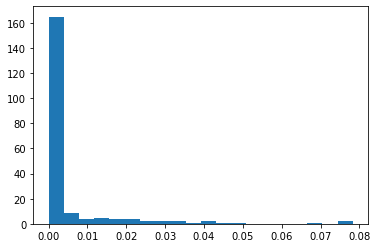

In [19]:
# Plotting a histogram of the importances to find heuristic cutoff for best features:
importances = rf_clf.feature_importances_
plt.hist(importances, bins=20);

In [221]:
# Getting extracted features:
cutoff = importances > 0
std_masked_feature_list = [feature for feature, mask_val in zip(lda_feature_list, std_mask) if mask_val]
important_features = [feature for feature, mask_val in zip(std_masked_feature_list, cutoff) if mask_val]

In [222]:
# Running PCA on image features with non-trivial importance from random forest:
pca_model = PCA(n_components=3)
pca_embeddings = pca_model.fit_transform(normed_array[:, cutoff])

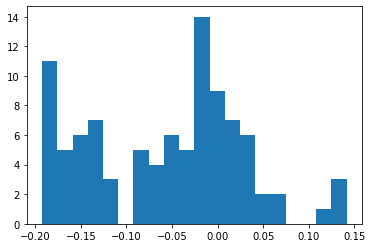

In [223]:
# Looking at the distribution of the weightings of the first principal component:
weights = pca_model.components_
plt.hist(weights[0], bins=20);

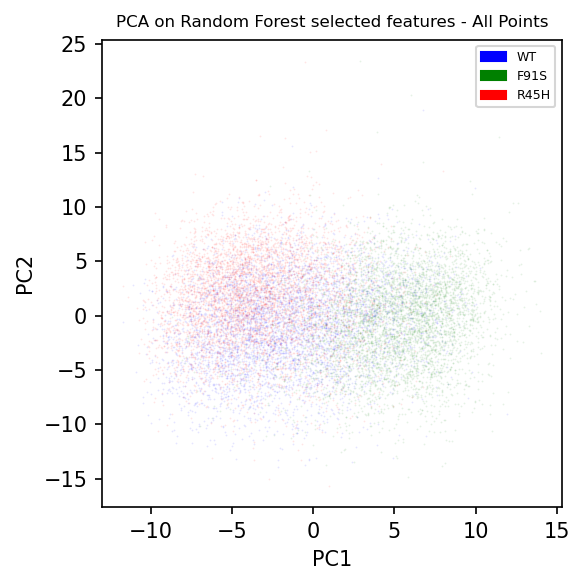

In [224]:
# Plotting first two principal components of PCA:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WT", "F91S", "R45H"]
col_labels = np.array(['b', 'g', 'r'])

count = 0
for cond_num in range(3):
    cond_arr = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = pca_embeddings[start_idx:end_idx, :]
        cond_arr.append(arr)
    cond_arr = np.concatenate(cond_arr, axis=0)
    ax.scatter(
        x=cond_arr[:, 0], y=cond_arr[:, 1], s=3, marker=".", alpha=0.1,
        c=col_labels[cond_num], label=str_labels[cond_num], linewidths=0
    )
    
# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, str_labels, prop={'size': 6})

# Titling figure:
plt.title(label="PCA on Random Forest selected features - All Points", fontsize=8);
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Saving figure:
plt.tight_layout()

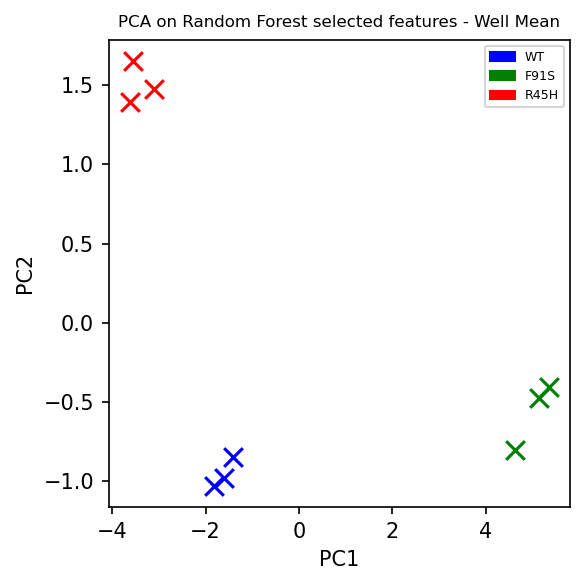

In [225]:
# Generating well averages plot:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WT", "F91S", "R45H"]
col_labels = np.array(['b', 'g', 'r'])

count = 0
for cond_num in range(3):
    cond_averages = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = pca_embeddings[start_idx:end_idx, :]
        well_average = np.mean(arr, axis=0)
        cond_averages.append(well_average)
    cond_averages = np.stack(cond_averages, axis=0)
    ax.scatter(
        x=cond_averages[:, 0], y=cond_averages[:, 1], s=80, marker="x",
        c=col_labels[cond_num], label=str_labels[cond_num]
    )

# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, str_labels, prop={'size': 6}, loc=0)

# Titling figure:
plt.title(label="PCA on Random Forest selected features - Well Mean", fontsize=8);
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Saving figure:
plt.tight_layout()
# plt.savefig(fname="TB MON Figure Output/PCA on Random Forest selected features - Well Mean.png", format="png")

In [20]:
# Performing LDA and transforming along most discriminable direction:
lda_clf = LinearDiscriminantAnalysis(n_components=2)
lda_embeddings = lda_clf.fit_transform(normed_array, label_array)

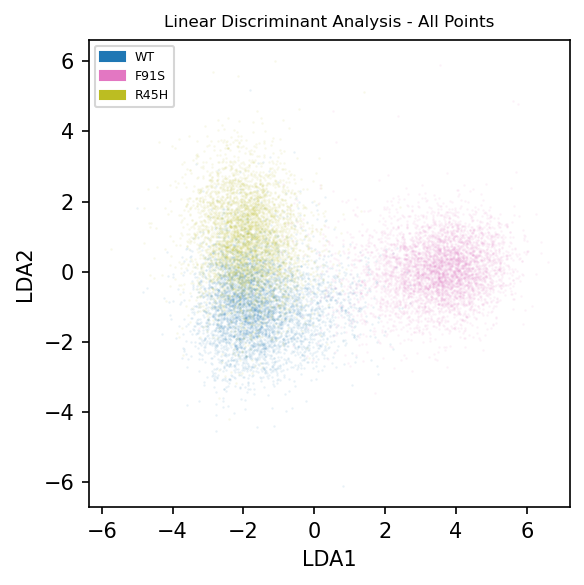

In [21]:
# Plotting first two components of LDA dimension reduction:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WT", "F91S", "R45H"]
col_labels = np.array(['tab:blue', 'tab:pink', 'tab:olive'])

count = 0
for cond_num in range(3):
    cond_arr = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = lda_embeddings[start_idx:end_idx, :]
        cond_arr.append(arr)
    cond_arr = np.concatenate(cond_arr, axis=0)
    ax.scatter(
        x=cond_arr[:, 0], y=cond_arr[:, 1], s=5, marker=".", alpha=0.1,
        c=col_labels[cond_num], label=str_labels[cond_num], linewidths=0
    )

# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, str_labels, prop={'size': 6})

# Titling figure:
plt.title(label="Linear Discriminant Analysis - All Points", fontsize=8);
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')

# Saving figure:
plt.tight_layout()
plt.savefig(fname="M2 Mutant Analysis/Output Figures/Linear Discriminant Analysis - All Points.png", format="png")

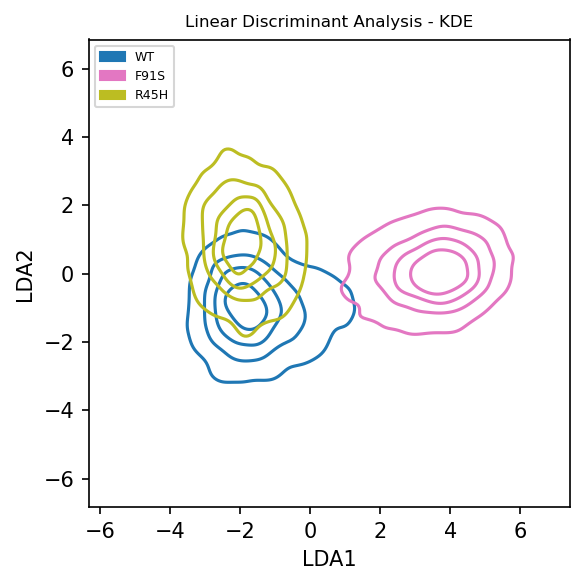

In [22]:
# Formatting data:
plot_dataset = [
    pd.DataFrame(lda_embeddings[label_array == 0, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 1, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 2, :], columns=["LDA1", "LDA2"]),
]

# Formatting data:
str_labels = ["WT", "F91S", "R45H"]
plot_dataset = pd.concat(plot_dataset, keys=str_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.kdeplot(
    data=plot_dataset, x="LDA1", y="LDA2", hue="Condition",
    ax=ax, palette=col_labels, levels=5, thresh=.1,
)

colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, str_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="Linear Discriminant Analysis - KDE", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="M2 Mutant Analysis/Output Figures/Linear Discriminant Analysis - KDE.png", format="png")

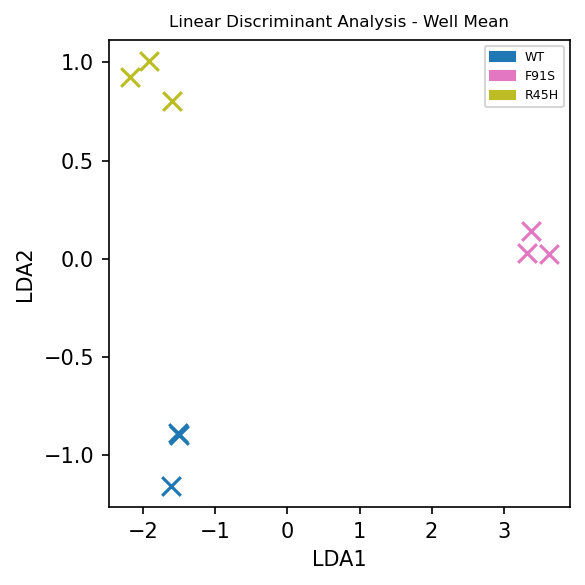

In [23]:
# Generating well averages plot:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WT", "F91S", "R45H"]
col_labels = np.array(['tab:blue', 'tab:pink', 'tab:olive'])

count = 0
for cond_num in range(3):
    cond_averages = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = lda_embeddings[start_idx:end_idx, :]
        well_average = np.mean(arr, axis=0)
        cond_averages.append(well_average)
    cond_averages = np.stack(cond_averages, axis=0)
    ax.scatter(
        x=cond_averages[:, 0], y=cond_averages[:, 1], s=80, marker="x",
        c=col_labels[cond_num], label=str_labels[cond_num]
    )

# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, str_labels, prop={'size': 6}, loc=0)

# Titling figure:
plt.title(label="Linear Discriminant Analysis - Well Mean", fontsize=8);
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')

# Saving figure:
plt.tight_layout()
plt.savefig(fname="M2 Mutant Analysis/Output Figures/Linear Discriminant Analysis - Well Mean.png", format="png")

## 2 Discriminability for single channel features:

In [24]:
# Performing LDA and transforming along most discriminable direction on solely M2-derived features:
m2_lda_clf = LinearDiscriminantAnalysis(n_components=2)
m2_lda_embeddings = m2_lda_clf.fit_transform(m2_array, label_array)

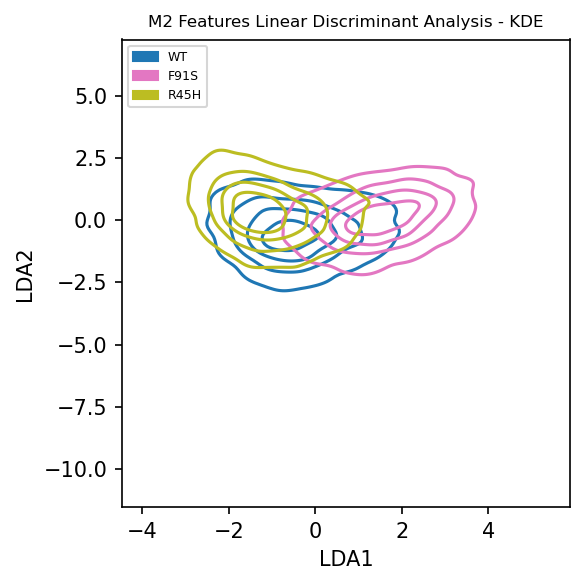

In [25]:
# Formatting data:
plot_dataset = [
    pd.DataFrame(m2_lda_embeddings[label_array == 0, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(m2_lda_embeddings[label_array == 1, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(m2_lda_embeddings[label_array == 2, :], columns=["LDA1", "LDA2"]),
]

# Formatting data:
str_labels = ["WT", "F91S", "R45H"]
plot_dataset = pd.concat(plot_dataset, keys=str_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.kdeplot(
    data=plot_dataset, x="LDA1", y="LDA2", hue="Condition",
    ax=ax, palette=col_labels, levels=5, thresh=.1,
)

colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, str_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="M2 Features Linear Discriminant Analysis - KDE", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="M2 Mutant Analysis/Output Figures/M2 Features Linear Discriminant Analysis - KDE.png", format="png")

In [26]:
# Performing LDA and transforming along most discriminable direction on solely M2-derived features:
gfplc3_lda_clf = LinearDiscriminantAnalysis(n_components=2)
gfplc3_lda_embeddings = gfplc3_lda_clf.fit_transform(gfplc3_array, label_array)

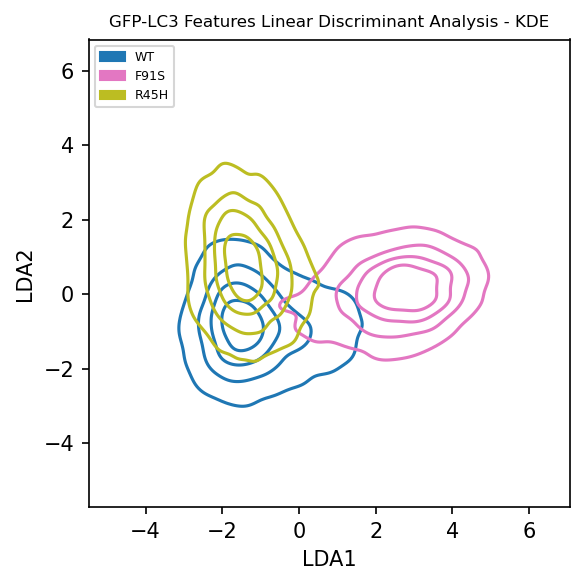

In [27]:
# Formatting data:
plot_dataset = [
    pd.DataFrame(gfplc3_lda_embeddings[label_array == 0, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(gfplc3_lda_embeddings[label_array == 1, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(gfplc3_lda_embeddings[label_array == 2, :], columns=["LDA1", "LDA2"]),
]

# Formatting data:
str_labels = ["WT", "F91S", "R45H"]
plot_dataset = pd.concat(plot_dataset, keys=str_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.kdeplot(
    data=plot_dataset, x="LDA1", y="LDA2", hue="Condition",
    ax=ax, palette=col_labels, levels=5, thresh=.1,
)

colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, str_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="GFP-LC3 Features Linear Discriminant Analysis - KDE", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="M2 Mutant Analysis/Output Figures/GFP-LC3 Features Linear Discriminant Analysis - KDE.png", format="png")

## 3 Calculating Wasserstein distances

In [37]:
def get_embedding_arrays(embeddings):
    count = 0
    condition_dict = {}
    for condition in range(3):
        condition_arrays = []
        for repeat in range(3):
            # Selecting data:
            start_idx = collapse_indices[count]
            end_idx = collapse_indices[count+1]
            count += 1
            cr_embeddings = embeddings[start_idx:end_idx, :]
            condition_arrays.append(cr_embeddings)
        condition_dict[condition] = condition_arrays
    return condition_dict

def calculate_combined_distances(condition_dict):
    # Calculating distances:
    cond_distances = []
    for i in range(3):
        list_condA = condition_dict[i]
        list_condB = condition_dict[(i+1)%3]

        # Calculating distance:
        distance_list = []
        for j in range(3):
            cond_A = list_condA[j]
            cond_B = list_condB[j]
            distance_LDA1 = wasserstein_distance(cond_A[:, 0], cond_B[:, 0])
            distance_LDA2 = wasserstein_distance(cond_A[:, 1], cond_B[:, 1])
            distance = distance_LDA1 + distance_LDA2
            distance_list.append(distance)
        cond_distances.append(distance_list)
    return cond_distances

In [38]:
# Total Feature Distances:
total_dict = get_embedding_arrays(lda_embeddings)
total_dists = calculate_combined_distances(total_dict)
total_dists

[[6.121935122626095, 5.920617033845156, 6.061771746537955],
 [6.417774464189424, 6.169099513083261, 6.004567418402929],
 [2.6592852520967925, 2.319372694519526, 1.869359893234324]]

In [39]:
# M2 Feature Distances:
m2_dict = get_embedding_arrays(m2_lda_embeddings)
m2_dists = calculate_combined_distances(m2_dict)
m2_dists

[[2.504726146024743, 2.3767192259292056, 2.645205813516476],
 [2.889071711680908, 2.7289709336151775, 2.806137828497711],
 [1.5504989798881037, 1.4458465688963749, 1.3747997231706188]]

In [40]:
# GFP-LC3 Feature Distances:
gfplc3_dict = get_embedding_arrays(gfplc3_lda_embeddings)
gfplc3_dists = calculate_combined_distances(gfplc3_dict)
gfplc3_dists

[[4.543575949817208, 4.527286825029561, 4.550292968291954],
 [4.63927631569663, 4.703537159955152, 4.588386505901513],
 [1.856153387506218, 1.8979822132981228, 1.72859306594856]]

## 4 Exporting populations unique to F91S

In [509]:
# Retrieving coefficients that drive distinction of WTMON:
f91s_coefs = lda_clf.coef_[1, :].flatten()
f91s_decision_values = np.sum(normed_array * f91s_coefs, axis=1)

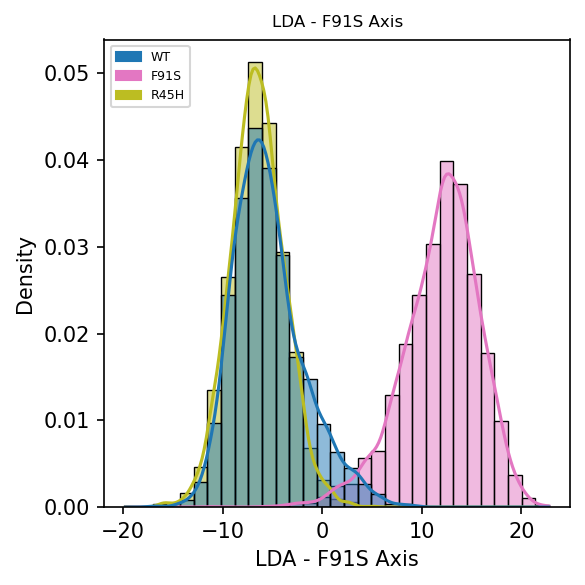

In [535]:
# Formatting data:
plot_dataset = [
    pd.Series(f91s_decision_values[label_array == 0].flatten(), name="LDA - F91S Axis"),
    pd.Series(f91s_decision_values[label_array == 1].flatten(), name="LDA - F91S Axis"),
    pd.Series(f91s_decision_values[label_array == 2].flatten(), name="LDA - F91S Axis"),
]

# Formatting data:
key_labels = ["WT", "F91S", "R45H"]
plot_dataset = pd.concat(plot_dataset, keys=key_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.histplot(
    x="LDA - F91S Axis", stat="density", hue="Condition",
    data=plot_dataset, ax=ax, palette=col_labels, kde=True
)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, key_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="LDA - F91S Axis", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="M2 Mutant Analysis/Output Figures/LDA - F91S Axis.png", format="png")

In [581]:
# Exporting population file for use in IDEAS:
idx = 6

start_idx = collapse_indices[idx]
end_idx = collapse_indices[idx+1]
arr = f91s_decision_values[start_idx:end_idx]
upper_mask = arr > np.quantile(arr, 0.85)
lower_mask = arr < np.quantile(arr, 0.15)
identifiable_obj_list = list(pd_dict["F91S1_0"][0:1600]["Object Number"][upper_mask])
noise_obj_list = list(pd_dict["F91S1_0"][0:1600]["Object Number"][lower_mask])

full_text = ""
for obj in identifiable_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/f91s1_id.pop", "w") as fout:
    fout.write(full_text)

full_text = ""
for obj in noise_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/f91s1_noise.pop", "w") as fout:
    fout.write(full_text)

## 5 Exporting populations unique to R45H

In [594]:
# Retrieving coefficients that drive distinction of WTMON:
r45h_coefs = lda_clf.coef_[2, :].flatten()
r45h_decision_values = np.sum(normed_array * r45h_coefs, axis=1)

# Retrieving coefficients that drive distinction of WTMON - GFPLC3 Features:
GFP_r45h_coefs = gfplc3_lda_clf.coef_[2, :].flatten()
GFP_r45h_decision_values = np.sum(gfplc3_array * GFP_r45h_coefs, axis=1)


# Retrieving coefficients that drive distinction of WTMON - M2 Features:
M2_r45h_coefs = m2_lda_clf.coef_[2, :].flatten()
M2_r45h_decision_values = np.sum(m2_array * M2_r45h_coefs, axis=1)

6.418921463396173
2.4598157976467068


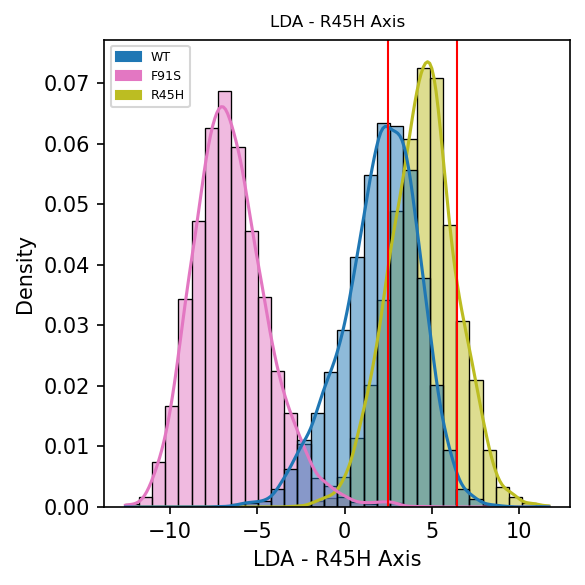

In [595]:
# Formatting data:
plot_dataset = [
    pd.Series(r45h_decision_values[label_array == 0].flatten(), name="LDA - R45H Axis"),
    pd.Series(r45h_decision_values[label_array == 1].flatten(), name="LDA - R45H Axis"),
    pd.Series(r45h_decision_values[label_array == 2].flatten(), name="LDA - R45H Axis"),
]

# Formatting data:
key_labels = ["WT", "F91S", "R45H"]
plot_dataset = pd.concat(plot_dataset, keys=key_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.histplot(
    x="LDA - R45H Axis", stat="density", hue="Condition",
    data=plot_dataset, ax=ax, palette=col_labels, kde=True
)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, key_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="LDA - R45H Axis", fontsize=8);

# Drawing cutoff for unique population:
lda_r45H_upper_cutoff = np.quantile(r45h_decision_values[label_array == 2], 0.85)
print(lda_r45H_upper_cutoff)
lda_r45H_lower_cutoff = np.quantile(r45h_decision_values[label_array == 2], 0.15)
print(lda_r45H_lower_cutoff)


plt.axvline(x=upper_cutoff, linewidth=1, color='r')
plt.axvline(x=lower_cutoff, linewidth=1, color='r')

# Saving figure:
plt.tight_layout()
plt.savefig(fname="M2 Mutant Analysis/Output Figures/LDA - R45H Axis.png", format="png")

In [587]:
# Exporting population file for use in IDEAS:
idx = 6

start_idx = collapse_indices[idx]
end_idx = collapse_indices[idx+1]
arr = r45h_decision_values[start_idx:end_idx]
upper_mask = arr > np.quantile(arr, 0.85)
lower_mask = arr < np.quantile(arr, 0.15)
identifiable_obj_list = list(pd_dict["R45H1_0"][0:1600]["Object Number"][upper_mask])
noise_obj_list = list(pd_dict["R45H1_0"][0:1600]["Object Number"][lower_mask])

full_text = ""
for obj in identifiable_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/r45h1_id.pop", "w") as fout:
    fout.write(full_text)

full_text = ""
for obj in noise_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/r45h1_noise.pop", "w") as fout:
    fout.write(full_text)

In [588]:
# Exporting population file for use in IDEAS:
idx = 6

start_idx = collapse_indices[idx]
end_idx = collapse_indices[idx+1]
arr = GFP_r45h_decision_values[start_idx:end_idx]
upper_mask = arr > np.quantile(arr, 0.85)
lower_mask = arr < np.quantile(arr, 0.15)
identifiable_obj_list = list(pd_dict["R45H1_0"][0:1600]["Object Number"][upper_mask])
noise_obj_list = list(pd_dict["R45H1_0"][0:1600]["Object Number"][lower_mask])

full_text = ""
for obj in identifiable_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/lc3_r45h1_id.pop", "w") as fout:
    fout.write(full_text)

full_text = ""
for obj in noise_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/lc3_r45h1_noise.pop", "w") as fout:
    fout.write(full_text)

In [589]:
# Exporting population file for use in IDEAS:
idx = 6

start_idx = collapse_indices[idx]
end_idx = collapse_indices[idx+1]
arr = M2_r45h_decision_values[start_idx:end_idx]
upper_mask = arr > np.quantile(arr, 0.85)
lower_mask = arr < np.quantile(arr, 0.15)
identifiable_obj_list = list(pd_dict["R45H1_0"][0:1600]["Object Number"][upper_mask])
noise_obj_list = list(pd_dict["R45H1_0"][0:1600]["Object Number"][lower_mask])

full_text = ""
for obj in identifiable_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/m2_r45h1_id.pop", "w") as fout:
    fout.write(full_text)

full_text = ""
for obj in noise_obj_list:
    full_text = full_text + f"{obj},\n"
with open("M2 Mutant Analysis/Output Population Files/m2_r45h1_noise.pop", "w") as fout:
    fout.write(full_text)

## 6 Plotting individual feature distributions

In [504]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Modulation_Cytoplasm_Ch11"]
internal_m2 = data_array[:, feature_index]

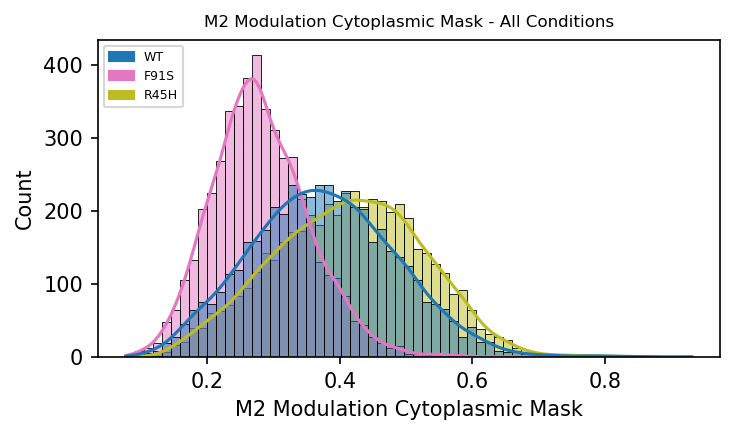

In [602]:
# Formatting data:
plot_dataset = [
    pd.Series(internal_m2[label_array == 0].flatten(), name="M2 Modulation Cytoplasmic Mask"),
    pd.Series(internal_m2[label_array == 1].flatten(), name="M2 Modulation Cytoplasmic Mask"),
    pd.Series(internal_m2[label_array == 2].flatten(), name="M2 Modulation Cytoplasmic Mask")
]

# Formatting data:
plot_dataset = pd.concat(plot_dataset, keys=["WT", "F91S", "R45H"], names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

# Plotting and labelling:
sns.histplot(
    data=plot_dataset, ax=ax, palette=col_labels, stat="count",
    hue="Condition", x="M2 Modulation Cytoplasmic Mask", kde=True)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, ["WT", "F91S", "R45H"], loc=2, prop={'size': 6});

# Titling figure:
plt.title(label="M2 Modulation Cytoplasmic Mask - All Conditions", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(
    fname="M2 Mutant Analysis/Output Figures/M2 Internal Localisation - All Conditions.png", format="png"
)

In [506]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Bright Detail Intensity R3_M02_Ch02"]
bdi_gfplc3 = data_array[:, feature_index]

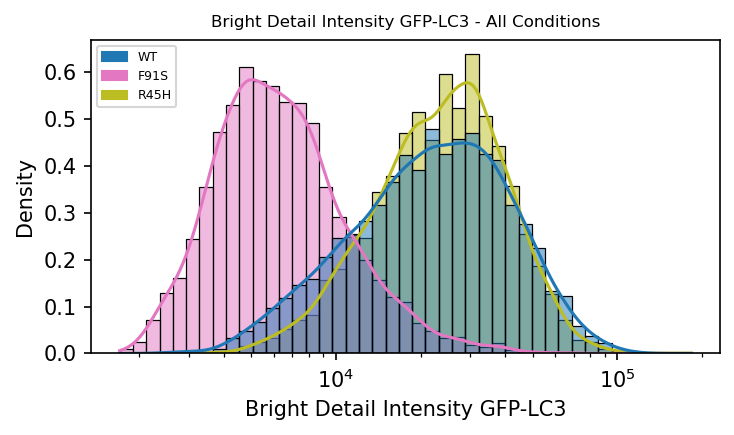

In [601]:
# Formatting data:
plot_dataset = [
    pd.Series(bdi_gfplc3[label_array == 0].flatten(), name="Bright Detail Intensity GFP-LC3"),
    pd.Series(bdi_gfplc3[label_array == 1].flatten(), name="Bright Detail Intensity GFP-LC3"),
    pd.Series(bdi_gfplc3[label_array == 2].flatten(), name="Bright Detail Intensity GFP-LC3")
]

# Formatting data:
plot_dataset = pd.concat(plot_dataset, keys=["WT", "F91S", "R45H"], names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

# Plotting and labelling:
sns.histplot(
    data=plot_dataset, ax=ax, palette=col_labels, stat="density",
    hue="Condition", x="Bright Detail Intensity GFP-LC3", kde=True, log_scale=True)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, ["WT", "F91S", "R45H"], loc=2, prop={'size': 6});

# Titling figure:
plt.title(label="Bright Detail Intensity GFP-LC3 - All Conditions", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(
    fname="M2 Mutant Analysis/Output Figures/Bright Detail Intensity GFP-LC3 - All Conditions.png", format="png"
)

In [41]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Intensity_MC_Ch11"]
m2_intensity = data_array[:, feature_index]

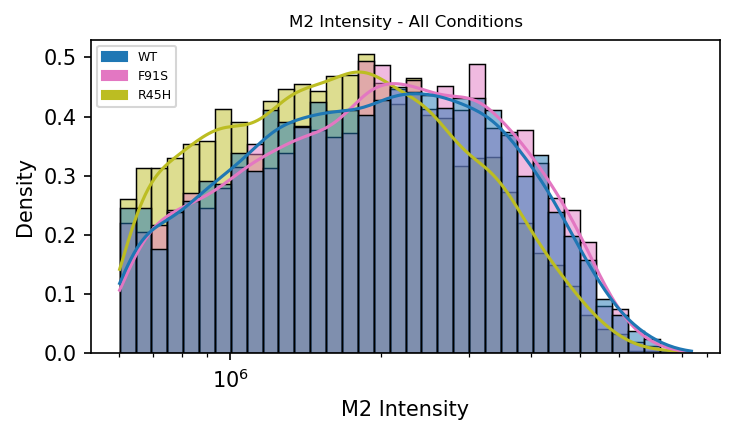

In [45]:
# Formatting data:
plot_dataset = [
    pd.Series(m2_intensity[label_array == 0].flatten(), name="M2 Intensity"),
    pd.Series(m2_intensity[label_array == 1].flatten(), name="M2 Intensity"),
    pd.Series(m2_intensity[label_array == 2].flatten(), name="M2 Intensity")
]

# Formatting data:
plot_dataset = pd.concat(plot_dataset, keys=["WT", "F91S", "R45H"], names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:pink', 'tab:olive']
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

# Plotting and labelling:
sns.histplot(
    data=plot_dataset, ax=ax, palette=col_labels, stat="density",
    hue="Condition", x="M2 Intensity", kde=True, log_scale=True)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(3)]
ax.legend(colour_patches, ["WT", "F91S", "R45H"], loc=2, prop={'size': 6});

# Titling figure:
plt.title(label="M2 Intensity - All Conditions", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(
    fname="M2 Mutant Analysis/Output Figures/M2 Intensity - All Conditions.png", format="png"
)

## 5 Outputs to PRISM

In [590]:
# Exporting M2 Modulation value:
count = 0
for cond_num in range(3):
    cond_averages = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = internal_m2[start_idx:end_idx]
        well_average = np.mean(arr, axis=0)[0]
        cond_averages.append(well_average)
    print(list(cond_averages))

[0.3740385331161164, 0.37712788967115984, 0.3755406859804998]
[0.27838231593304336, 0.28404590716482686, 0.28351056666086455]
[0.40769278882455795, 0.41839936436308234, 0.4145898446657165]


In [591]:
# Exporting Bright Detail Intensity R3:
count = 0
for cond_num in range(3):
    cond_averages = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = bdi_gfplc3[start_idx:end_idx]
        well_average = np.mean(arr, axis=0)[0]
        cond_averages.append(well_average)
    print(list(cond_averages))

[26886.422498941123, 25070.10684601359, 25906.204341420234]
[7759.010621532798, 7235.054999084175, 7328.624363434091]
[27770.73624601066, 26296.388172816038, 25598.588134886028]


In [46]:
# Exporting M2 Intensity:
count = 0
for cond_num in range(3):
    cond_averages = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = m2_intensity[start_idx:end_idx]
        well_average = np.mean(arr, axis=0)[0]
        cond_averages.append(well_average)
    print(list(cond_averages))

[2250148.542857588, 2271119.6697728555, 2216819.208599104]
[2289363.1551909135, 2369538.815763029, 2210954.635719596]
[1958684.9272626224, 1901866.2852429063, 1937983.648263166]


In [ ]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Intensity"]
bdi_gfplc3 = data_array[:, feature_index]

In [599]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Intensity_MC_Ch11"]
value_arr = data_array[:, feature_index]

# Exporting feature values in different R45H populations:
upper_list = []
lower_list = []
count = 6
for idx in range(3):
    start_idx = collapse_indices[count]
    end_idx = collapse_indices[count+1]
    count += 1
    
    lda_arr = r45h_decision_values[start_idx:end_idx]
    upper_mask = lda_arr > lda_r45H_upper_cutoff
    lower_mask = lda_arr < lda_r45H_lower_cutoff
    
    upper_value_arr = value_arr[start_idx:end_idx][upper_mask]
    lower_value_arr = value_arr[start_idx:end_idx][lower_mask]
    
    upper_list.append(np.mean(upper_value_arr))
    lower_list.append(np.mean(lower_value_arr))

print(lower_list)
print(upper_list)

[2796638.5052199843, 2602497.300699194, 2386963.6033305805]
[1477458.165506481, 1477306.9302445909, 1395770.3168518743]


In [1]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Bright Detail Intensity R3_M02_Ch02"]
value_arr = data_array[:, feature_index]

# Exporting feature values in different R45H populations:
upper_list = []
lower_list = []
count = 6
for idx in range(3):
    start_idx = collapse_indices[count]
    end_idx = collapse_indices[count+1]
    count += 1
    
    lda_arr = r45h_decision_values[start_idx:end_idx]
    upper_mask = lda_arr > lda_r45H_upper_cutoff
    lower_mask = lda_arr < lda_r45H_lower_cutoff
    
    upper_value_arr = value_arr[start_idx:end_idx][upper_mask]
    lower_value_arr = value_arr[start_idx:end_idx][lower_mask]
    
    upper_list.append(np.mean(upper_value_arr))
    lower_list.append(np.mean(lower_value_arr))

print(lower_list)
print(upper_list)

NameError: name 'lda_feature_list' is not defined

In [112]:
def generate_quantiles(pd_dict, feature_to_quantile):
    np_arr_list = []
    for condition in pd_dict.keys():
        temp_np_array = pd_dict[condition].loc[:, feature_to_quantile].to_numpy()
        np_arr_list.append(temp_np_array)

    total_arr = np.concatenate(np_arr_list, axis=0)
    quantiles = np.quantile(total_arr, [0.02, 0.2, 0.4, 0.6,  0.8, 0.98])
    return quantiles

def return_quantile_means(feature_arr, quantile_arr, quantile_vals):
    means_list = []
    for i in range(len(quantile_vals) - 1):
        mask = (quantile_arr > quantile_vals[i]) & (quantile_arr < quantile_vals[i+1])
        temp_mean = np.mean(feature_arr[mask])
        means_list.append(temp_mean)
    return means_list

def generate_mean_quantile_values(pandas_dict, condition, quantile_feature, feature_value, quantile_vals, log=False):
    mean_list = []
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        query_data = pandas_dict[label][feature_value]
        quantile_data = pandas_dict[label][quantile_feature]
        if log:
            data = np.log(data[data>0])
        quantile_means = return_quantile_means(np.asarray(query_data), np.asarray(quantile_data), quantile_vals)
        mean_list.append(quantile_means)
    return mean_list

def compare_quantiles(pd_dict, query_cond, quantile_cond, quantiles):
    for cell_type in ["WT", "F91S", "R45H"]:
        print(generate_mean_quantile_values(pd_dict, cell_type, quantile_cond,  query_cond, quantiles))
        print("--- --- ---")

In [114]:
gfp_intensity_quantiles = generate_quantiles(pd_dict, "Intensity_MC_Ch02")

In [116]:
compare_quantiles(pd_dict, "Modulation_Cytoplasm_Ch11", "Intensity_MC_Ch02", gfp_intensity_quantiles)

[[0.3189914169949519, 0.32268704998266196, 0.3521943046647195, 0.3729331204415325, 0.4034499094526382], [0.30148680322949734, 0.3375437688844262, 0.3637218921651614, 0.3956184378926219, 0.41478733133227647], [0.3186704175362713, 0.3263131626624107, 0.35778395398658014, 0.38533836236423347, 0.40845705180595726]]
--- --- ---
[[0.26950727595754814, 0.2774532005169062, 0.27687809771750005, 0.29227313510073155, 0.28949125760530386], [0.27531098772234014, 0.2782931479964808, 0.2813106083399119, 0.2988527017578994, 0.3015051805286128], [0.27846042284621825, 0.28113379478425493, 0.2877180999307848, 0.3007982780088979, 0.29942973021297514]]
--- --- ---
[[0.4062825850383945, 0.37829721657662696, 0.38916978713695627, 0.41089690412085667, 0.42512346309225596], [0.404750605297618, 0.3837304740789742, 0.39228520159233715, 0.4223766690043697, 0.43427576576831795], [0.37448756686487167, 0.38990796204678246, 0.3969253267934956, 0.416898505091163, 0.4299737696799071]]
--- --- ---
